### Recommender example

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
sigmoid = lambda x: 1. / (1. + np.exp(-x))

In [4]:
def is_numeric(x):
    try:
        x + 1
    except:
        return False
    else:
        return True

# [(x, is_numeric(x)) for x in [0, 1, 2.345, 'hello', None, {12: 34}, [12, 23]]]

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [6]:
# Ruben's version
class TwoTowerModel(nn.Module):
    def __init__(self, users, items, embedding_dim=2, hidden_dims=[]):
        """users and items dataframes with columns as features."""

        super().__init__()       
        self.n_users, self.n_items, self.emb_dim = len(users), len(items), embedding_dim
        assert users.notnull().all().all() and items.notnull().all().all()
        
        self.user_emb = nn.Embedding(self.n_users, embedding_dim)
        self.item_emb = nn.Embedding(self.n_items, embedding_dim)
        self.cat_emb = [[], []]  # users, items
        self.cat_features = [[], []]  # users, items
        self.num_features = [[], []]  # users, items
        
        self.features = [[], []]
        for i, df in enumerate([users, items]):
            for col in df:
                is_num = is_numeric(df[col].iloc[0])
                if is_num:
                    self.num_features[i].append(torch.Tensor(df[[col]].values))  # store as Tensor
                else:
                    cat_ids, cat_names = df[col].factorize()
                    emb = nn.Embedding(len(cat_names), self.emb_dim)
                    self.cat_emb[i].append({'i': i, 'feature': col, 'categories': cat_names, 'emb': emb})
                    self.cat_features[i].append(np.array(cat_ids))  # np.arrays

        self.user_tower = MLP((1 + len(self.cat_emb[0])) * self.emb_dim + len(self.num_features[0]), hidden_dims, self.emb_dim)
        self.item_tower = MLP((1 + len(self.cat_emb[1])) * self.emb_dim + len(self.num_features[1]), hidden_dims, self.emb_dim)


    def forward(self, user_ids, item_ids):

        # User tower
        user_input = torch.cat(
            [self.user_emb(user_ids)] + 
            [emb['emb'](torch.Tensor(features[user_ids]).long()) for emb, features in zip(self.cat_emb[0], self.cat_features[0])] +
            [vals[user_ids] for vals in self.num_features[0]], dim=1)
        user_vec = self.user_tower(user_input)

        # Item tower input
        item_input = torch.cat(
            [self.item_emb(item_ids)] + 
            [emb['emb'](torch.Tensor(features[item_ids]).long()) for emb, features in zip(self.cat_emb[1], self.cat_features[1])] +
            [vals[item_ids] for vals in self.num_features[1]], dim=1)
        item_vec = self.item_tower(item_input)

        # Dot product similarity
        logits = (user_vec * item_vec).sum(dim=1)
        return logits

In [19]:
# Simulate user and item interactions
n_users = 100  # 1000
n_items =  20  # 500
n_imp = 2000
true_emb_dim = 2  # using this to simulate true interests
print("See %.1f%% of all possible interactions." % (100. * n_imp / (n_users * n_items)))

# Remove all features for now
np.random.seed(123)
user_true_emb = np.random.randn(n_users, true_emb_dim)
item_true_emb = np.random.randn(n_items, true_emb_dim)
users, items = pd.DataFrame({'dummy': np.zeros(n_users)}), pd.DataFrame({'dummy': np.zeros(n_items)})
# genders = ['male', 'non-binary', 'female']
# users = pd.DataFrame({
#     'age': np.maximum(18, 40 + 15 * np.random.randn(n_users)).astype(int),
#     'gender': np.random.choice(genders, n_users, p=[.49, .49, .02]),
# })
# topics = ['food', 'culture', 'civics', 'sports', 'science', 'business']  # just random categories
# items = pd.DataFrame({
#     'topic': np.random.choice(topics, n_items),  # uniform distribution
# })

# cat_features = [genders, topics]
# cat_emb = {category: np.random.randn(true_emb_dim) for feature in cat_features for category in feature}
# emb = np.random.randn(n_users, true_emb_dim) \
#     + (users['age'] / users['age'].max()).values.reshape(-1, 1) \
#     + np.array(users['gender'].map(cat_emb).tolist())
# emb = (emb - emb.mean(axis=1).reshape(-1, 1)) / emb.std(axis=1).reshape(-1, 1) 
# user_true_emb = emb 
# emb = np.random.randn(n_items, true_emb_dim) + np.array(items['topic'].map(cat_emb).tolist())
# emb = (emb - emb.mean(axis=1).reshape(-1, 1)) / emb.std(axis=1).reshape(-1, 1)
# item_true_emb = emb

p_true = sigmoid(user_true_emb.dot(item_true_emb.T))  # true proability of user i liking item j
print(p_true.shape, p_true.mean())

# generate responses
torch.manual_seed(123)
# user_ids = torch.randint(0, n_users, (n_imp,))
# item_ids = torch.randint(0, n_items, (n_imp,))
# labels = torch.Tensor(p_true[user_ids, item_ids] < np.random.rand(n_imp))  # probabilitic
# labels = torch.Tensor(p_true[user_ids, item_ids] > .5)  # deterministic

user_ids = torch.Tensor(np.array([i + np.zeros(n_items) for i in range(n_users)]).reshape(-1)).long()
item_ids = torch.Tensor(np.array(([np.arange(n_items)] * n_users)).reshape(-1)).long()
labels = torch.Tensor(np.array([p_true[user][item] for user, item in zip(user_ids, item_ids)]) > .5)  # deterministic
print(labels.numpy().mean())
# labels

See 100.0% of all possible interactions.
(100, 20) 0.5038154958427765
0.512


In [20]:
# torch hyperparameters
lr = 0.01
n_epochs = 300
n_print = 10

In [21]:
torch.manual_seed(1234)
print(true_emb_dim)
model = TwoTowerModel(users, items, embedding_dim=2, hidden_dims=[])

# Training
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train / test split
frac_test = .1
test_idx = torch.rand(n_imp) < frac_test
train_idx = ~test_idx

# Training loop
stats = []
stop_epoch_delay = 1 * n_epochs // n_print
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    uids, iids = user_ids[train_idx], item_ids[train_idx]
    outputs = model.forward(uids, iids)
    loss = criterion(outputs, labels[train_idx])

    test_outputs = model.forward(user_ids[test_idx], item_ids[test_idx])
    test_loss = criterion(test_outputs, labels[test_idx])
    
    loss.backward()
    optimizer.step()
    
    stats.append({'epoch': epoch, 'loss': loss.item(), 'test loss': test_loss.item()})
    if epoch % (n_epochs // n_print) == 0:
        print(f"Epoch {epoch+1:4}, Loss: {loss.item():.4f}, Test loss: {test_loss.item():.4f}")

    if len(stats) > stop_epoch_delay and stats[-stop_epoch_delay]['test loss'] > stats[-stop_epoch_delay - 1]['test loss']:
        stats[-stop_epoch_delay - 1]['stop'] = True
        break
stats[-1]['stop'] = True        
stats = pd.DataFrame(stats).set_index('epoch')

2
Epoch    1, Loss: 0.7098, Test loss: 0.7201
Epoch   31, Loss: 0.6806, Test loss: 0.6909
Epoch   61, Loss: 0.5600, Test loss: 0.6271
Epoch   91, Loss: 0.4301, Test loss: 0.4679
Epoch  121, Loss: 0.3827, Test loss: 0.4107
Epoch  151, Loss: 0.3674, Test loss: 0.3894
Epoch  181, Loss: 0.3584, Test loss: 0.3729
Epoch  211, Loss: 0.3525, Test loss: 0.3628
Epoch  241, Loss: 0.3483, Test loss: 0.3584


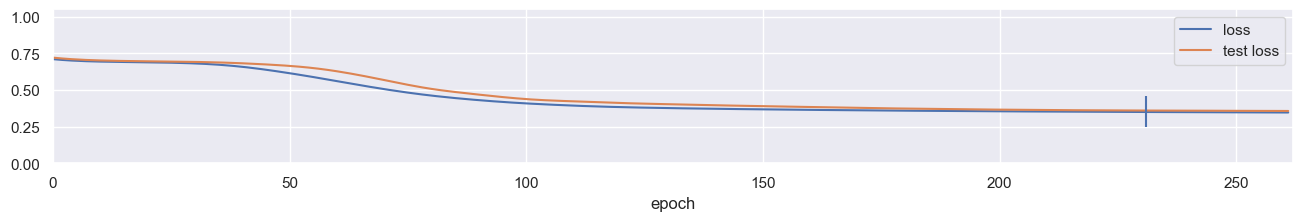

In [22]:
ax = stats.plot(figsize=(16, 2))
x = stats['stop'].dropna().index[0]
ax.vlines(x, stats['loss'][x] - .1, stats['test loss'][x] + .1)
_ = ax.set_xlim(0, len(stats)), ax.set_ylim(0, 1.05 * stats.max().max())

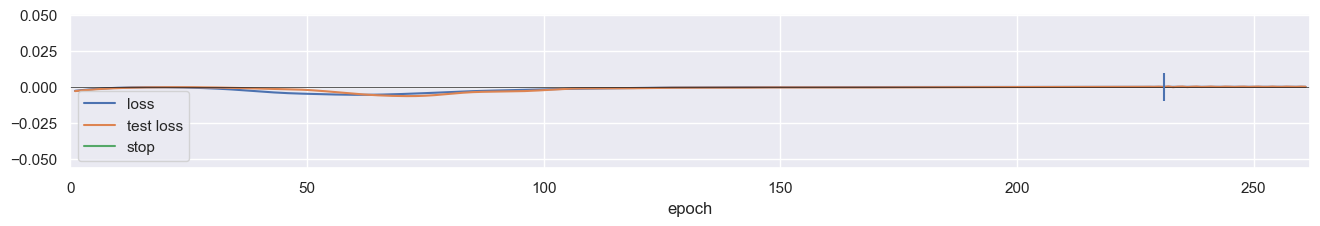

In [23]:
df = stats.diff()
ax = df.plot(figsize=(16, 2))
ax.axhline(0, lw=.5, color='k')
ax.vlines(x, df['loss'][x] - .01, df['test loss'][x] + .01)
_ = ax.set_xlim(0, len(stats)), ax.set_ylim(df.min().min() - .05, df.max().max() + .05)

In [24]:
y_pred = sigmoid(outputs.detach().numpy()).round(2)
y = labels[train_idx].detach().numpy()

print('prev ', labels.numpy().mean())
print('train auc %.4f  acc %.4f  p %.4f  r %.4f' % 
      (roc_auc_score(y, y_pred), (y_pred.astype(int) == y).mean(), y_pred[y.astype(bool)].mean(), y[y_pred.astype(bool)].mean()))

y_pred = sigmoid(test_outputs.detach().numpy()).round(2)
y = labels[test_idx].detach().numpy()
print('test  auc %.4f  acc %.4f  p %.4f  r %.4f' % 
      (roc_auc_score(y, y_pred), (y_pred.astype(int) == y).mean(), y_pred[y.astype(bool)].mean(), y[y_pred.astype(bool)].mean()))

prev  0.512
train auc 0.9006  acc 0.6497  p 0.7625  r 0.6003
test  auc 0.9076  acc 0.5909  p 0.7439  r 0.6284


/var/folders/6c/26c6hdd139z0614_0r1t44lm0000gn/T/ipykernel_77194/36728285.py:1: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1. / (1. + np.exp(-x))
